# ****Importing Modules and Packages****

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import imghdr
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from keras.models import Model
from keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from tensorflow.keras.callbacks import EarlyStopping
from PIL import ImageFile
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt
from IPython.display import display, Image
import random
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ****Image augmentation on train dataset and data split****

In [2]:
# train_datagen=ImageDataGenerator(featurewise_center=True, validation_split=0.06,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,preprocessing_function=preprocess_input,zoom_range=0.2,shear_range=0.2,fill_mode='nearest',brightness_range=[0.5, 1.5])
train_datagen=ImageDataGenerator(validation_split=0.1,preprocessing_function=preprocess_input,)
train_data=train_datagen.flow_from_directory(directory="/kaggle/input/anyas-gojo-revival-aerospace-enigma/train",target_size=(256,256),batch_size=50,subset = 'training')
validation_data=train_datagen.flow_from_directory(directory="/kaggle/input/anyas-gojo-revival-aerospace-enigma/train",target_size=(256,256),batch_size=50,subset = 'validation')

Found 2108 images belonging to 5 classes.
Found 233 images belonging to 5 classes.


# ****Data Visualization****

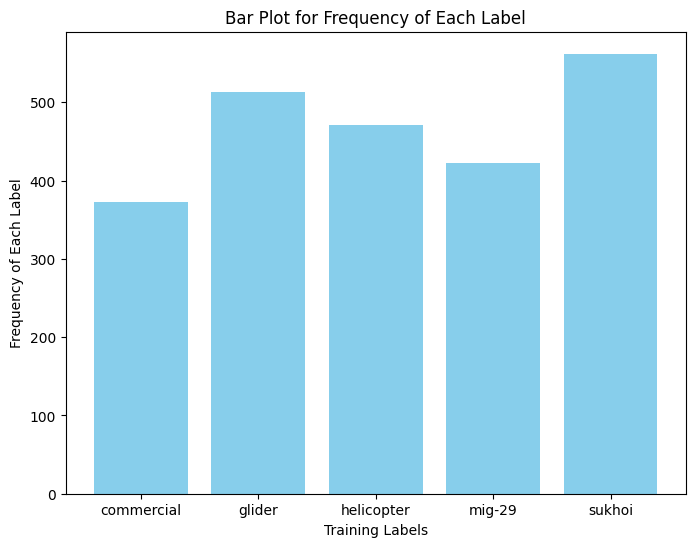

In [3]:
plt.figure(figsize=(8, 6))
plt.bar(["commercial","glider","helicopter","mig-29","sukhoi"],[len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/commercial")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/glider")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/helicopter")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/mig-29")),len(os.listdir("/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/sukhoi"))] , color='skyblue')
plt.xlabel('Training Labels')
plt.ylabel('Frequency of Each Label')
plt.title('Bar Plot for Frequency of Each Label')
plt.show()

In [4]:
def view_random_images():
    images = []
    labels = []
    root="/kaggle/input/anyas-gojo-revival-aerospace-enigma"
    for i in range(20):
        random_class = "/train/" +random.choice(list(train_data.class_indices.keys()))    
        random_path = root+random_class
        random_image = random.sample(os.listdir(random_path),2)
        images.append(random_path + '/' + random_image[0])
        labels.append(random_class)
    plt.figure(figsize=(25, 10))
    for i in range(1, 21):
        plt.subplot(7, 15, i)
        img = mpimg.imread(images[i-1])
        plt.imshow(img,aspect="auto")
        plt.title(labels[i-1].split("/")[-1])
        plt.axis(False)

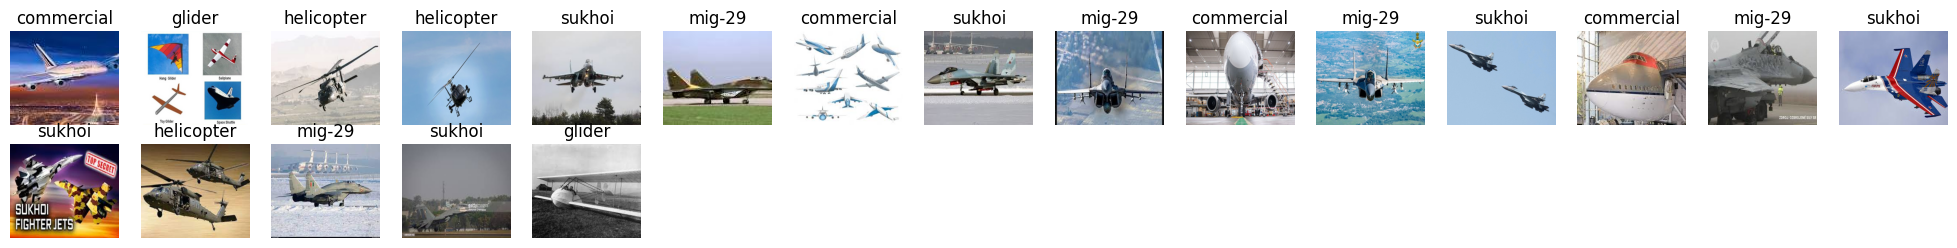

In [5]:
view_random_images()

# ****Model Training****

In [6]:
base_model=InceptionV3(input_shape=(256,256,3),include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable=False
x=base_model.output
x=layers.Flatten()(x)
x=Dense(units=512,activation='relu')(x)
x=Dropout(0.1)(x)
x=Dense(units=5,activation='softmax')(x)
model1=Model(base_model.input,x)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
history=model1.fit(train_data,steps_per_epoch=30,epochs=30,callbacks=[early_stopping],validation_data = validation_data,validation_steps = 1)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30
30/30 [==============================] - 32s 573ms/step - loss: 0.5015 - accuracy: 0.6262 - val_loss: 0.2061 - val_accuracy: 0.7800
Epoch 2/30
30/30 [==============================] - 11s 361ms/step - loss: 0.1592 - accuracy: 0.8580 - val_loss: 0.2020 - val_accuracy: 0.7400
Epoch 3/30
30/30 [==============================] - 10s 335ms/step - loss: 0.0980 - accuracy: 0.9220 - val_loss: 0.1597 - val_accuracy: 0.8200
Epoch 4/30
30/30 [==============================] - 10s 329ms/step - loss: 0.0713 - accuracy: 0.9553 - val_loss: 0.1917 - val_accuracy: 0.7800
Epoch 5/30
30/30 [==============================] - 9s 312ms/step - loss: 0.0485 - accuracy: 0.9801 - val_loss: 0.2123 - val_accuracy: 0.8000
Epoch 6/30
30/30 [==============================] - 9s 293ms/step - loss: 0.0412 - accuracy: 0.9813 - val_loss: 0.2210 - val_accuracy: 0.7800
Epoch 7/30
30/30 [==============================] - 9s 303ms/step - loss: 0.0284 - accuracy: 0.9863 - val_loss: 0.1956 - val_accuracy: 0.8400
Ep

# ****Prediction on test dataset****

In [9]:
test_path='/kaggle/input/anyas-gojo-revival-aerospace-enigma/test'
result={}
indices_dict={train_data.class_indices[i]:i for i in train_data.class_indices.keys()}
for img_path in os.listdir(test_path):
    path =os.path.join(test_path,img_path)
    img=load_img(path,target_size=(256,256))
    i=img_to_array(img)
    i=preprocess_input(i)
    pres=np.argmax(model1.predict(np.array([i])))
    result.update({img_path:indices_dict[pres]})

1/1 [==============================] - 0s 26ms/step


# ****Data visualizaton of Predicted array****

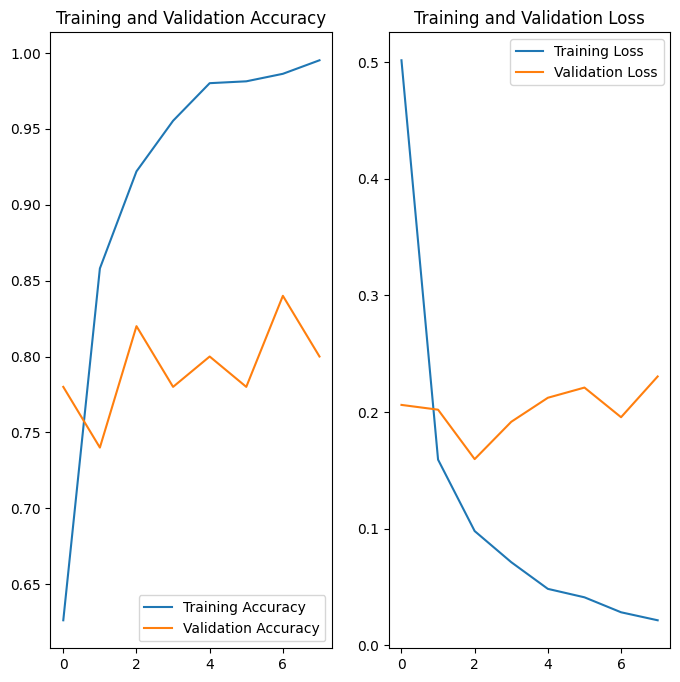

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

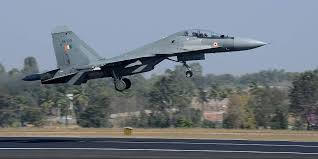

sukhoi


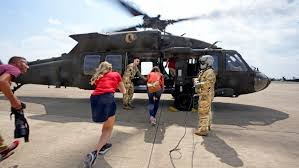

helicopter


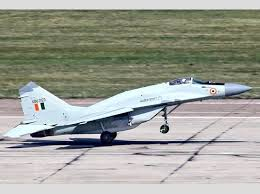

sukhoi


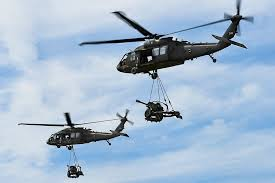

helicopter


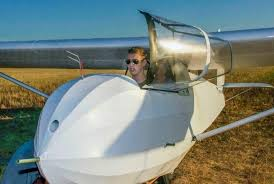

glider


In [11]:
for i in list(result.keys())[:5]:
    display(Image(os.path.join(test_path,i)))
    print(result[i])

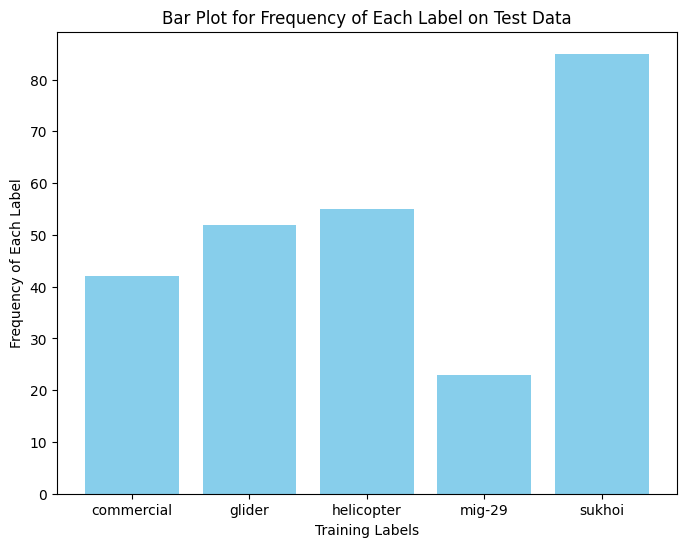

In [12]:
plt.figure(figsize=(8, 6))
plt.bar(["commercial","glider","helicopter","mig-29","sukhoi"],[list(result.values()).count("commercial"),list(result.values()).count("glider"),list(result.values()).count("helicopter"),list(result.values()).count("mig-29"),list(result.values()).count("sukhoi")],color='skyblue')
plt.xlabel('Training Labels')
plt.ylabel('Frequency of Each Label')
plt.title('Bar Plot for Frequency of Each Label on Test Data')
plt.show()

# ****Saving the Results****

In [13]:
submission=pd.DataFrame({'image_path':result.keys(),"Class":result.values()})
submission.to_csv("submission0ijhoiuygtfbf.csv", index=False)